# Run tasks in parallel

## Introduction
In this tutorial, you will learn how to run task in parallel.

Load the AiiDA profile.

In [3]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='57ccbf7d9e2b41b39edb2bfdaf725feb' name='default'>

## First workflow
Suppose we want to calculate ```(x + y) * z ``` in two steps. First, add `x` and `y`, then multiply the result with `z`. And `X` is a list of values. We want to calculate these in parallel.


### Create task
First, one should know that we can not launch a subprocess inside a `task` or a `calcfunction`. We need a create a `WorkGraph` to run tasksin parallel. And then treat this `WorkGraph` as a task.

In [7]:
from aiida_workgraph import task, WorkGraph


# define multiply task
@task.calcfunction()
def multiply(x, y):
    return x*y

# Create a WorkGraph as a task
@task.graph_builder()
def multiply_parallel(X, y):
    wg = WorkGraph()
    # here the task `multiply` is created and will run in parallel
    for key, value in X.items():
        wg.tasks.new(multiply, name=f"multiply_{key}", x=value, y=y)
    return wg

### Create the workflow


In [8]:
from aiida_workgraph import WorkGraph
from aiida.orm import Int, List

X = {"a": Int(1), "b": Int(2), "c": Int(3)}
y = Int(2)
z = Int(3)
wg = WorkGraph("parallel_tasks")
multiply_parallel1 = wg.tasks.new(multiply_parallel, name="multiply_parallel1", X=X, y=y)

wg.submit(wait=True)

WorkGraph process created, PK: 32084


<WorkChainNode: uuid: 5bee865c-c6e0-4ab1-bdce-5281003aeb86 (pk: 32084) (aiida_workgraph.engine.workgraph.WorkGraph)>

### Check the status and results


In [9]:
print("State of WorkGraph:   {}".format(wg.state))

State of WorkGraph:   FINISHED


Generate node graph from the AiiDA process:

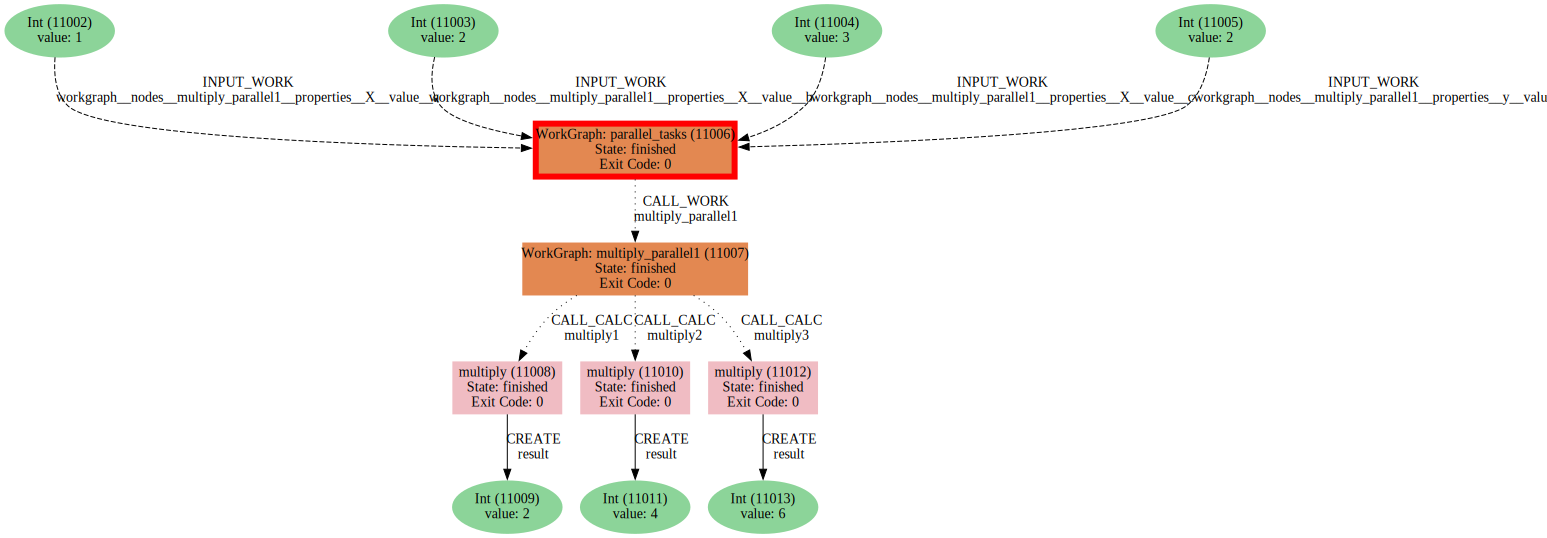

In [ ]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

## Second workflow: gather results
Now I want to gather the results from the previous `multiply_parallel` tasks and calculate the sum of all their results.
Let's update the `multiply_parallel` function to `multiply_parallel_gather`.

In [ ]:
@task.graph_builder(outputs = [{"name": "result", "from": "context.mul"}])
def multiply_parallel_gather(X, y):
    wg = WorkGraph()
    for key, value in X.items():
        multiply1 = wg.tasks.new(multiply, x=value, y=y)
        # add result of multiply1 to `self.context.mul`
        # self.context.mul is a dict {"a": value1, "b": value2, "c": value3}
        multiply1.set_context({"result": f"mul.{key}"})
    return wg

@task.calcfunction()
# the input is dynamic, we must use a variable kewword argument. **datas
def sum(**datas):
    from aiida.orm import Float
    total = 0
    for key, data in datas.items():
        total += data
    return Float(total)

Now, let's create a `WorkGraph` to use the new task:

In [ ]:
from aiida_workgraph import WorkGraph
from aiida.orm import Int, List

X = {"a": Int(1), "b": Int(2), "c": Int(3)}
y = Int(2)
z = Int(3)
wg = WorkGraph("parallel_tasks")
multiply_parallel_gather1 = wg.tasks.new(multiply_parallel_gather, X=X, y=y)
sum1 = wg.tasks.new(sum, name="sum1")
# wg.links.new(add1.outputs[0], multiply_parallel_gather1.inputs["uuids"])
wg.links.new(multiply_parallel_gather1.outputs[0], sum1.inputs[0])

wg.submit(wait=True)

WorkGraph process created, PK: 4431


Get the result of the tasks:

In [ ]:
print("State of WorkGraph:   {}".format(wg.state))
print('Result of task add1: {}'.format(wg.tasks["sum1"].outputs["result"].value))

State of WorkGraph:   FINISHED
Result of task add1: uuid: 4aefb7cf-df99-4562-95e3-f8942e790b18 (pk: 4441) value: 12.0


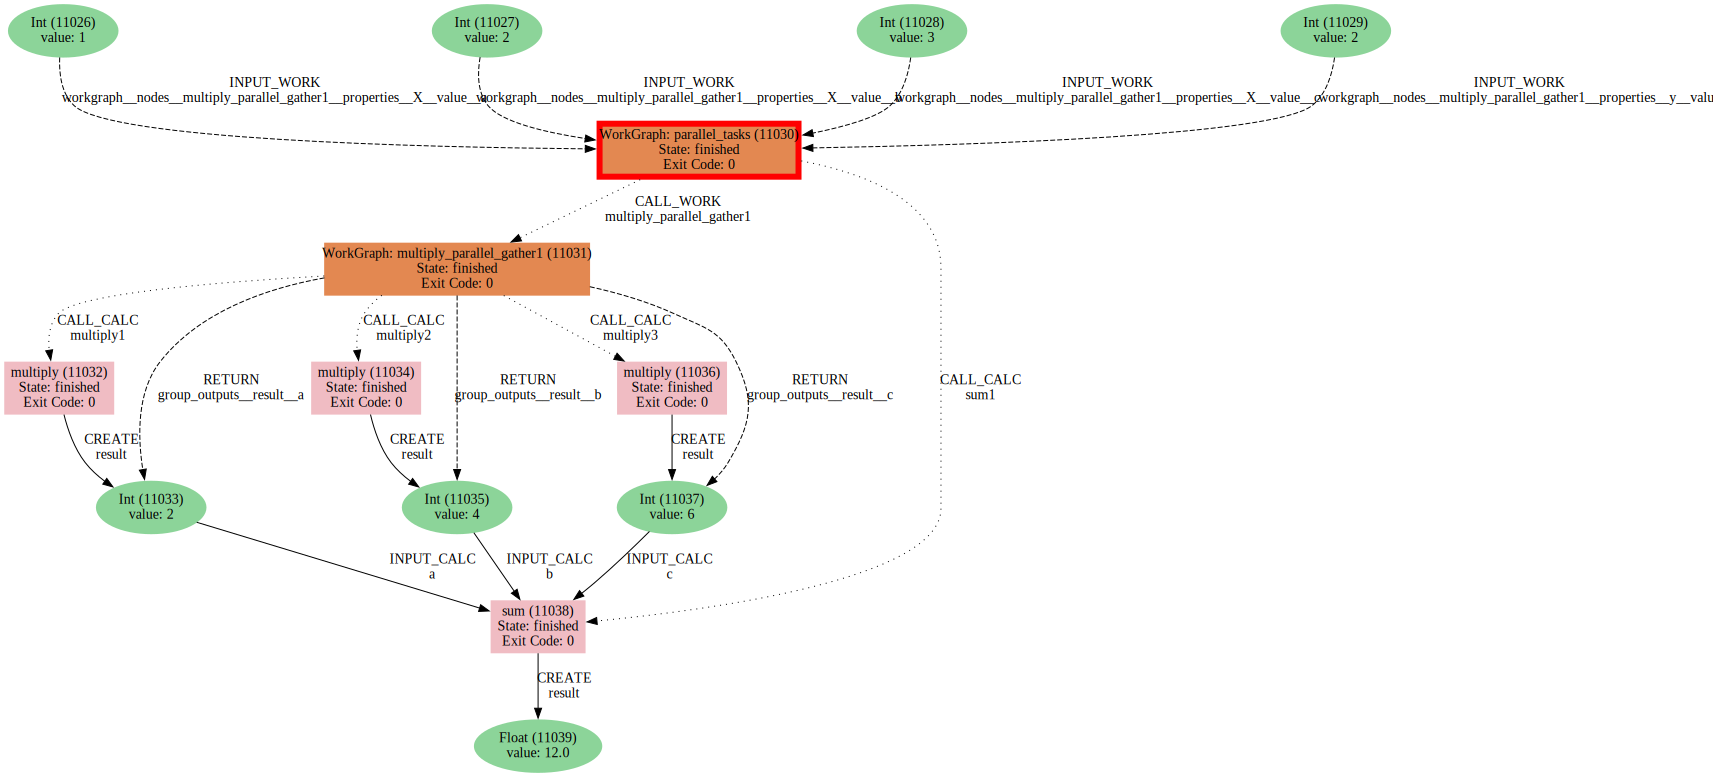

In [ ]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

You can see that the outputs of `multiply_parallel_gather` workgraph is linked to the input of the `sum` task.